<a href="https://colab.research.google.com/github/yaara-dev/brain-tumor/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import platform
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
gpu=torch.device('cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print("python version:", platform.python_version())
print("torch version:", torch.__version__)
print("torch cuda:", torch.cuda.is_available())
print("torch cuda version", torch.version.cuda)

python version: 3.7.10
torch version: 1.8.1+cu101
torch cuda: False
torch cuda version 10.1


Labels : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])


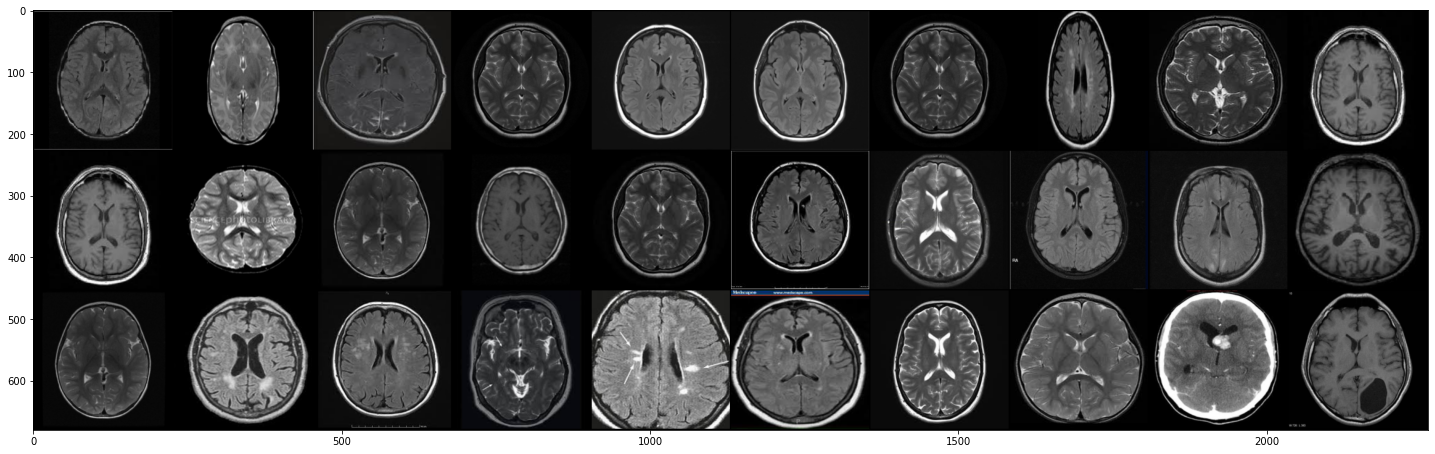

In [4]:
# training data, just for plotting
train_path='/content/drive/MyDrive/dataset/trainingset/'
validation_path='/content/drive/MyDrive/dataset/testset/'
nepochs = 15

dataset=torchvision.datasets.ImageFolder(
    root=train_path,
    transform=transforms.Compose([
    transforms.Resize((224 ,224)),    
    transforms.ToTensor()
]))

dataset_loader=torch.utils.data.DataLoader(
    dataset,
    batch_size=30
)

data = next(iter(dataset_loader))
images, labels = data
grid = torchvision.utils.make_grid(images, nrow = 10)
plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
print("Labels :", labels)
# image = images[1, :, :]
# print(image.shape)
# plt.imshow(np.transpose(image, (1,2,0)))

In [5]:
# channels_sum, channels_squared_sum, batch_size = 0, 0, 0
# for data, _ in dataset_loader:
#     channels_sum += torch.mean(data, dim=[0,2,3])
#     channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#     batch_size += 1
# mean = channels_sum/batch_size
# std = channels_squared_sum/batch_size

# print("training set mean is: ", mean)
# print("training set std is: ", std)

# # imagenet mean and std
# # mean = [0.485, 0.456, 0.406]
# # std = [0.229, 0.224, 0.225]

In [6]:

data_transforms=transforms.Compose([
    transforms.Resize((224 ,224))
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [7]:
train_data=torchvision.datasets.ImageFolder(
    root=train_path,
    transform=data_transforms
)
validation_data=torchvision.datasets.ImageFolder(
    root=validation_path,
    transform=data_transforms
)

In [8]:
train_loader=torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)
validation_loader=torch.utils.data.DataLoader(
    validation_data,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

In [9]:
print("Classes : ", train_data.class_to_idx)
print("Number of Training Samples : ", len(train_data))
print("Number of Validation Samples : ", len(validation_data))

Classes :  {'NO': 0, 'YES': 1}
Number of Training Samples :  168
Number of Validation Samples :  30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Shape: torch.Size([3, 224, 224])
Label:  Negative


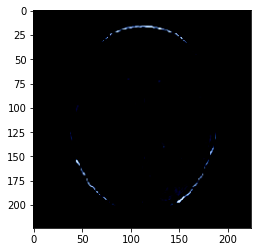

In [10]:
# plot sample image
sample = next(iter(train_data))
image, label = sample
print("Image Shape:", image.shape)

if label == 0:
    label = "Negative"
else :
    label = "Positive"

print("Label: ",label)

image = np.transpose(image, (1,2,0))
plt.imshow(image)

In [11]:
batch = next(iter(train_loader))
images, labels = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels : tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0])


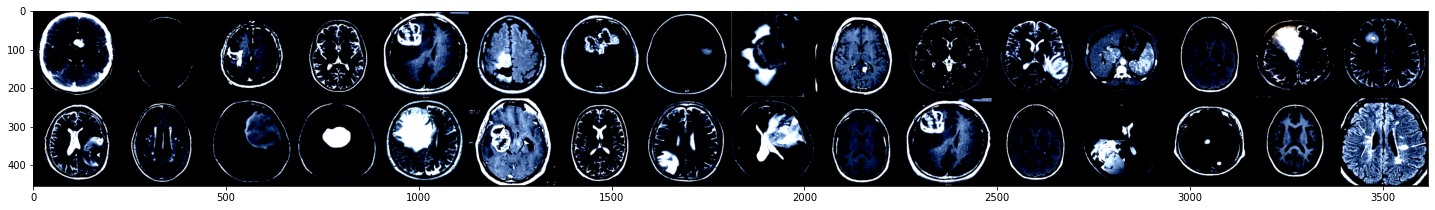

In [12]:
# normalized with dataset mean and std
grid = torchvision.utils.make_grid(images, nrow = 16)

plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
print("Labels :", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels : tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0])


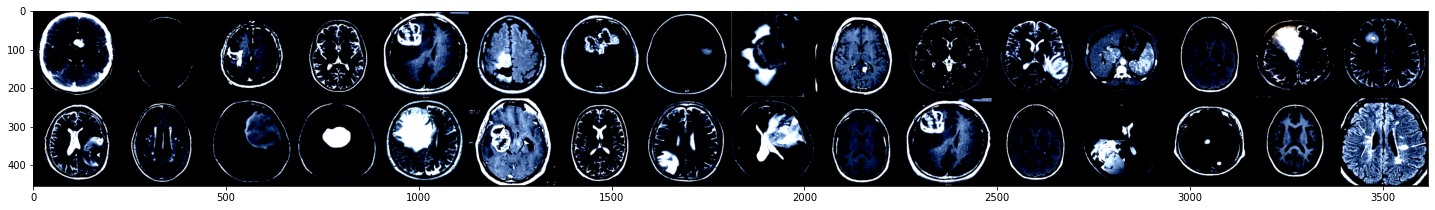

In [13]:
# normalized with imagenet mean and std
grid = torchvision.utils.make_grid(images, nrow = 16)

plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
print("Labels :", labels)

In [14]:
# the model
model = models.vgg11(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [15]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - total_trainable_params
print('Total Parameters: ',total_params)
print('Total Trainable Parameters: ',total_trainable_params)
print('Total Non Trainable Parameters: ',non_trainable_params)

Total Parameters:  132863336
Total Trainable Parameters:  132863336
Total Non Trainable Parameters:  0


In [16]:
for param in model.features.parameters():
    param.requires_grad=False

gap = nn.AdaptiveAvgPool2d((1, 1))
first_fc_layer=nn.Linear(512, 1024)
second_fc_layer=nn.Linear(1024, 1024)
last_fc_layer=nn.Linear(1024, 2)
do1=torch.nn.Dropout(p=0, inplace=False)
do2=torch.nn.Dropout(p=0, inplace=False)

model.avgpool = gap
model.classifier[0]=first_fc_layer
model.classifier[3]=second_fc_layer
model.classifier[6]=last_fc_layer
model.classifier[2]=do1
model.classifier[5]=do2
if torch.cuda.is_available():
    model.to('cuda')

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [17]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - total_trainable_params
print('Total Parameters: ',total_params)
print('Total Trainable Parameters: ',total_trainable_params)
print('Total Non Trainable Parameters: ',non_trainable_params)

Total Parameters:  10797442
Total Trainable Parameters:  1576962
Total Non Trainable Parameters:  9220480


In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
loss_history=[]
corrects_history=[]
val_loss_history=[]
val_corrects_history=[]
val_loss_min = np.inf

for epoch in range(nepochs ): 
    
    t0 = time.time()
    running_loss=0.0
    running_corrects=0.0
    val_running_loss=0.0
    val_running_corrects=0.0
    
    model.train()
    for images,labels in train_loader:
        if torch.cuda.is_available():
          images=images.to(gpu)
          labels=labels.to(gpu)
        outputs=model(images)
        loss=criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        _, preds=torch.max(outputs, 1)
        running_corrects+=torch.sum(preds==labels.data)
    
    else:
        model.eval()
        with torch.no_grad():
            for val_images,val_labels, in validation_loader:
                if torch.cuda.is_available():

                  val_images=val_images.to(gpu)
                  val_labels=val_labels.to(gpu)
                val_outputs=model(val_images)
                val_loss=criterion(val_outputs, val_labels)
                
                val_running_loss+=val_loss.item()
                _, val_preds=torch.max(val_outputs, 1)
                val_running_corrects+=torch.sum(val_preds==val_labels.data)

    epoch_loss=running_loss/len(train_loader.dataset)
    epoch_acc=running_corrects.float()/len(train_loader.dataset) 
    loss_history.append(epoch_loss)
    corrects_history.append(epoch_acc)

    val_epoch_loss=val_running_loss/len(validation_loader.dataset)
    val_epoch_acc=val_running_corrects.float()/len(validation_loader.dataset) 
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
        }
    
    # torch.save(checkpoint, r'checkpoint\vgg16gap_epoch_{}.pth'.format(epoch + 1))

    print('epoch: ', (epoch + 1))

    print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
    print('epoch time: {:.4f} seconds'.format(time.time() - t0))

    if val_epoch_loss <= val_loss_min:
        print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min,        val_epoch_loss))
        torch.save(checkpoint, r'checkpoint\vgg16_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
        val_loss_min = val_epoch_loss

epoch:  1
training loss: 0.0226, acc: 0.6429
validation loss: 0.0239, acc: 0.5000
epoch time: 56.7078 seconds
validation loss decreased from inf to 0.0239, saving model...
epoch:  2
training loss: 0.0212, acc: 0.6845
validation loss: 0.0257, acc: 0.5000
epoch time: 56.1882 seconds
epoch:  3
training loss: 0.0201, acc: 0.6845
validation loss: 0.0242, acc: 0.5000
epoch time: 56.1074 seconds
epoch:  4
training loss: 0.0186, acc: 0.6845
validation loss: 0.0220, acc: 0.5000
epoch time: 56.0604 seconds
validation loss decreased from 0.0239 to 0.0220, saving model...
epoch:  5
training loss: 0.0191, acc: 0.6964
validation loss: 0.0206, acc: 0.5333
epoch time: 56.3284 seconds
validation loss decreased from 0.0220 to 0.0206, saving model...
epoch:  6
training loss: 0.0163, acc: 0.8214
validation loss: 0.0186, acc: 0.7333
epoch time: 56.2360 seconds
validation loss decreased from 0.0206 to 0.0186, saving model...
epoch:  7
training loss: 0.0153, acc: 0.8750
validation loss: 0.0198, acc: 0.6000
e

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(loss_history, color = 'red')
plt.plot(val_loss_history, color = 'darkgreen')
plt.plot(corrects_history, color = 'magenta')
plt.plot(val_corrects_history, color = 'blue')
plt.title('Model Loss/Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss', 'train_acc', 'val_acc'], loc='center right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
# plt.savefig(r'graphs\vgg16_acc_loss.png', dpi = 100)

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(corrects_history, color = 'magenta')
plt.plot(val_corrects_history, color = '#606060')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
# plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
# plt.savefig(r'graphs\vgg16_acc.png', dpi = 100)

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(loss_history, color = 'magenta')
plt.plot(val_loss_history, color = '#606060')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
# plt.savefig(r'graphs\vgg16_loss.png', dpi = 100)

In [ ]:
#torch.save(model.state_dict(), r'model\vgg16.pth')